# Labelling Famous Landmarks (Explainability)

This is the last phase of my data science project about the **Google Landmark Recognition 2020** dataset. The main objective of this notebook is to try to explain and understand a little more about how the builded neural networks work classifying images. 

# Index of Contents

1.   Loading modules and data
2.   Xception architecture
3.   VGG architecture
4.   Conclusions

# Load modules and data


In [ ]:
from tensorflow.keras.applications import xception
from tensorflow.keras.applications import vgg16
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import random

In addition to the usual libraries that I have used in previous notebooks, this time I will make use of my own utility file. It contains functions adapted to my needs taken from the official Keras website. These functionalities are the ones that provides the model interpretability that I am looking for.

In [ ]:
# own modules 
import utils
from GradVisualizer import GradVisualizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We also need some images, so I have opted to use one of the test sets from previous steps of the project.

In [ ]:
! unzip -qq '/content/drive/MyDrive/4º de Carrera/TFG/test_20.zip'

In [ ]:
! ls -a 

.   .config  GradVisualizer.py	sample_data  utils.py
..  drive    __pycache__	..test_20


In [ ]:
# set a seed for reproducible experiments
seed = 487

At first my intention was to evaluate my own models with unofficial third party libraries, however I could not get them to work. The root of the problem was the way I had built my models in the form of blocks. Each block was composed of certain layers or an entire model. That is why I have opted to use functions from some of the computer vision articles I found in the Keras and Tensorflow documentation. 

So my idea is to see how decisions are made by the original architectures of the two applications I have used: **Xception** and **VGG**. As both are the cornerstones of my own models, the intention is to try to understand a bit more about the predictions they have made. In this way, in future works their performance can be improved.

First of all the images to work with must be extracted from the test set that is already loaded. The following steps show how to obtain them randomly. To ensure the reproducibility of the experiment, the same seed will always be used.

In [ ]:
path = f"..test_20/"
_, classes, _ = next(os.walk(path))
print(classes)

['36748', '161902', '20120', '120734', '9070', '139894', '10419', '46705', '20409', '177870', '176528', '83144', '149980', '194914', '168098', '113209', '45428', '1924', '126637', '176018']


In [ ]:
random.seed(seed)
label = random.choice(classes)
print(f"Selected class: {label}")

176018


In [ ]:
images_paths = utils.get_random_class_images(f"..test_20/{label}/", 9, seed)
print(images_paths)

['..test_20/176018/d1bd7b1328a5b161.jpg', '..test_20/176018/76e30f657ec364f6.jpg', '..test_20/176018/2866ae1c3cd4b098.jpg', '..test_20/176018/1e9a7a8c0179dbfe.jpg', '..test_20/176018/96e7d19c3258b9cc.jpg', '..test_20/176018/3de316976280d037.jpg', '..test_20/176018/cd08ff433cdf5006.jpg', '..test_20/176018/d04d1aa9e19e223e.jpg', '..test_20/176018/1c8d8d18c0c617f0.jpg']


# Xception architecture

The first thing to do is load the model and the different functions that it provides us. These last ones are necessary for the model to work with the images.

In [ ]:
model= xception.Xception(weights="imagenet")
img_size = (299, 299)  #input size for Xception
preprocess_input = xception.preprocess_input
decode_predictions = xception.decode_predictions

91889664/91884032 [==============================] - 1s 0us/step


Let's take a look at the predictions made by Xception on the extracted example images.

40960/35363 [==================================] - 0s 0us/step


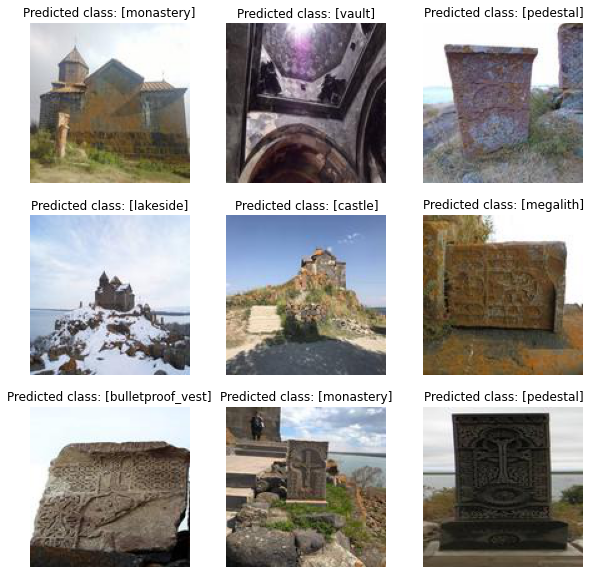

In [ ]:
utils.plot_images_prediction(images_paths, img_size, model, preprocess_input, decode_predictions)

What is most striking, as always, is the diversity of scenes presented to us within the same class. This intr-class variation is the major reason why the builded models cannot learn to distinguish between classes. Therefore is logical to expect this outcome. Xception has predicted all the images with different categories belonging to the ImageNet database and it seems to be obvious. A human will do the same if he does not know the context of the whole class.

For the **GradCam** algortihm it is required a convolutional layer to attach the activations for the creation of the heatmap.

In [ ]:
layers = [layer.name for layer in model.layers]
print(layers)

['input_1', 'block1_conv1', 'block1_conv1_bn', 'block1_conv1_act', 'block1_conv2', 'block1_conv2_bn', 'block1_conv2_act', 'block2_sepconv1', 'block2_sepconv1_bn', 'block2_sepconv2_act', 'block2_sepconv2', 'block2_sepconv2_bn', 'conv2d', 'block2_pool', 'batch_normalization', 'add', 'block3_sepconv1_act', 'block3_sepconv1', 'block3_sepconv1_bn', 'block3_sepconv2_act', 'block3_sepconv2', 'block3_sepconv2_bn', 'conv2d_1', 'block3_pool', 'batch_normalization_1', 'add_1', 'block4_sepconv1_act', 'block4_sepconv1', 'block4_sepconv1_bn', 'block4_sepconv2_act', 'block4_sepconv2', 'block4_sepconv2_bn', 'conv2d_2', 'block4_pool', 'batch_normalization_2', 'add_2', 'block5_sepconv1_act', 'block5_sepconv1', 'block5_sepconv1_bn', 'block5_sepconv2_act', 'block5_sepconv2', 'block5_sepconv2_bn', 'block5_sepconv3_act', 'block5_sepconv3', 'block5_sepconv3_bn', 'add_3', 'block6_sepconv1_act', 'block6_sepconv1', 'block6_sepconv1_bn', 'block6_sepconv2_act', 'block6_sepconv2', 'block6_sepconv2_bn', 'block6_sep

In [ ]:
last_conv_layer_name = layers[-3]
print(last_conv_layer_name)

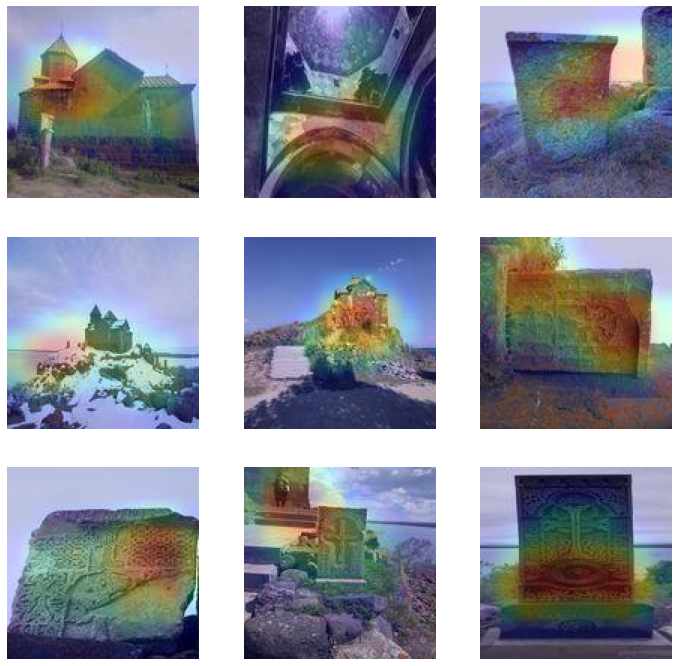

In [ ]:
utils.plot_gradcam_images(images_paths, img_size, model, preprocess_input, last_conv_layer_name)

The centres of attention are usually quite large compared to the size of the images, but still concentrated in specific areas. This effectively denotes the characteristics that have categorized each image. As every image is different from the other. they do not have any common features, so the previous predictions make even more sense now.

The other model interpretability tecnqiue that I am going to apply is called **Integrated Gradients**. It aims to explain the relationship between the model's predictions in terms of its features. This can gives clues about the significance of the different features.

Predicted: monastery


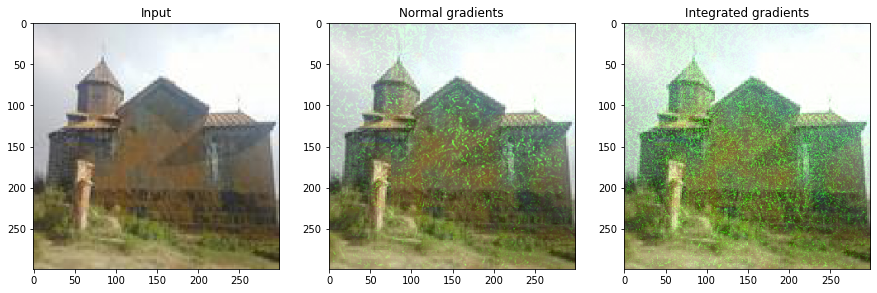

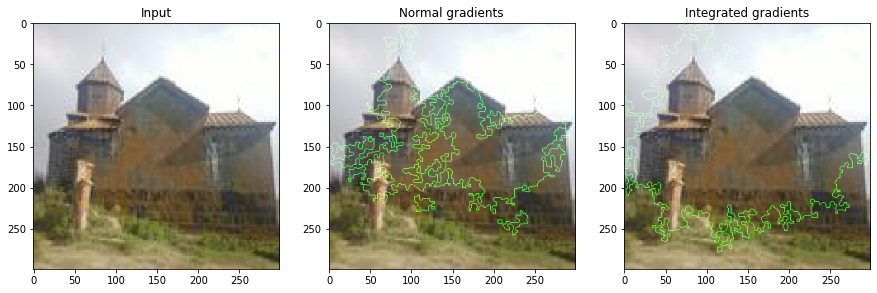

In [ ]:
# Adding a dimension to the image size for the integrated gradients
img_size = (299, 299, 3)

#Take the first photo from the previous ones
img = utils.get_img_array(images_paths[0], img_size)
orig_img = np.copy(img[0]).astype(np.uint8)
img_processed = tf.cast(preprocess_input(img), dtype=tf.float32)

preds = model.predict(img_processed)
top_pred_idx = tf.argmax(preds[0])
print("Predicted:", decode_predictions(preds, top=1)[0][0][1])

grads = utils.get_gradients(img_processed, model, top_pred_idx=top_pred_idx)
igrads = utils.random_baseline_integrated_gradients(
    img_input=np.copy(orig_img), 
    img_size=img_size, 
    model=model, 
    preprocess_input=preprocess_input, 
    top_pred_idx=top_pred_idx, 
    num_steps=50, 
    num_runs=2
)

vis = GradVisualizer()
vis.visualize(
    image=orig_img,
    gradients=grads[0].numpy(),
    integrated_gradients=igrads.numpy(),
    clip_above_percentile=99,
    clip_below_percentile=0,
)

vis.visualize(
    image=orig_img,
    gradients=grads[0].numpy(),
    integrated_gradients=igrads.numpy(),
    clip_above_percentile=90,
    clip_below_percentile=30,
    morphological_cleanup=True,
    outlines=True,
)

Taking the first photo above as an example, the most important features of this one can be seen in green. The integrated gradients are what the neural network looks at to make its prediction. In one of the visualizations the gradients are represented as isolated pixels, while in the other tehy are group into areas. Interestingly, this area mostly coincides with the previous heat map.

It can be said that the network is doing its job well in this case, since its prediction is a monastery and the part that stands out is precisely the building in question.

# VGG architecture

Teh same procedure is done, but this time with the VGG16 application

In [ ]:
model= vgg16.VGG16(weights="imagenet")
img_size = (224, 224)  #input size for VGG 
preprocess_input = vgg16.preprocess_input
decode_predictions = vgg16.decode_predictions

In [ ]:
layers = [layer.name for layer in model.layers]
print(layers)

['input_3', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool', 'flatten', 'fc1', 'fc2', 'predictions']


The last convolutional layer is taken for the **GradCAM** algorithm.

In [ ]:
last_conv_layer_name = layers[-6]
print(last_conv_layer_name)

block5_conv3


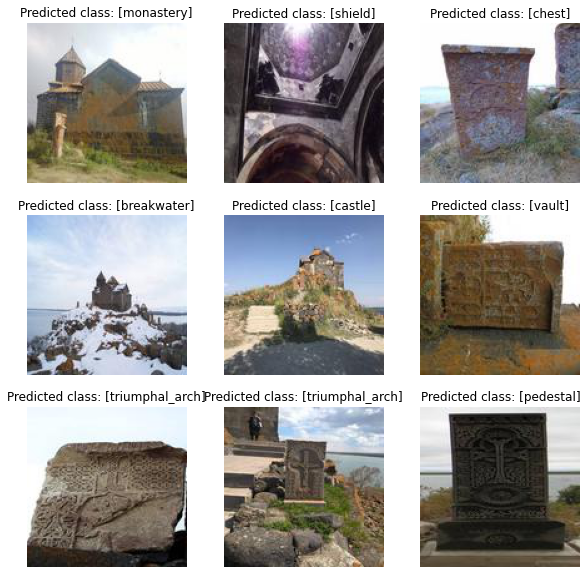

In [ ]:
utils.plot_images_prediction(images_paths, img_size, model, preprocess_input, decode_predictions)

Again the same effect happens as with the previous architecture, all images are classified as different classes, which is pretty obvious for the same reason as before. What is interesting is that the predictions of both neural networks do not match. All the predicted classes for the images are different with the exception of the first one.

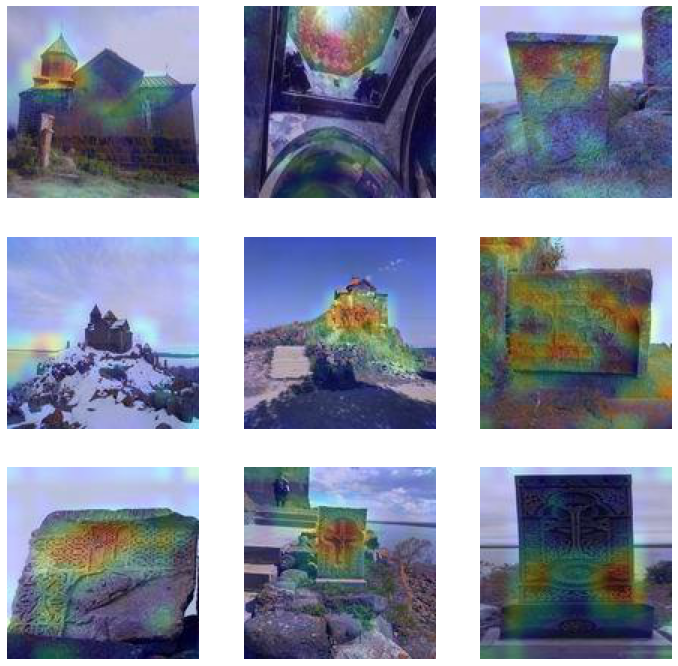

In [ ]:
utils.plot_gradcam_images(images_paths, img_size, model, preprocess_input, last_conv_layer_name)

With the heat maps it becomes clear why VGG has made different predictions. Its centers of attention in the photos are different and even appear to be weaker. By this I mean that they do not represent a large part of the image as it happends in the Xception case. The main reason for this is the way the layers of the model are structured and also the type of layers that have been used in each case.Therefore, these interpretability techniques can be of great help in understanding what is going on inside these black boxes and improving their aspects.

Predicted: monastery


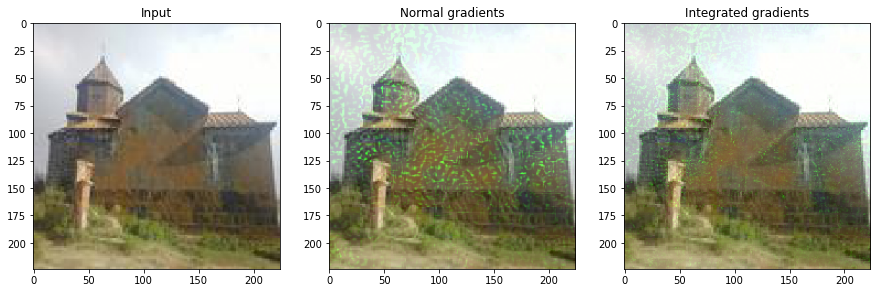

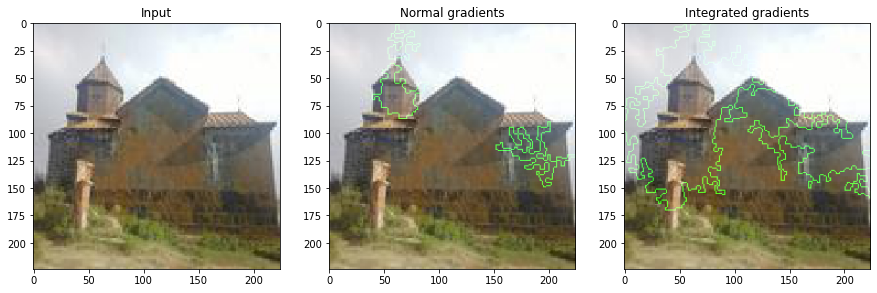

In [ ]:
# Adding a dimension to the image size for the integrated gradients
img_size = (224, 224, 3)

#Take the first photo from the previous ones
img = utils.get_img_array(images_paths[0], img_size)
orig_img = np.copy(img[0]).astype(np.uint8)
img_processed = tf.cast(preprocess_input(img), dtype=tf.float32)

preds = model.predict(img_processed)
top_pred_idx = tf.argmax(preds[0])
print("Predicted:", decode_predictions(preds, top=1)[0][0][1])

grads = utils.get_gradients(img_processed, model, top_pred_idx=top_pred_idx)
igrads = utils.random_baseline_integrated_gradients(
    img_input=np.copy(orig_img), 
    img_size=img_size, 
    model=model, 
    preprocess_input=preprocess_input, 
    top_pred_idx=top_pred_idx, 
    num_steps=50, 
    num_runs=2
)

vis = GradVisualizer()
vis.visualize(
    image=orig_img,
    gradients=grads[0].numpy(),
    integrated_gradients=igrads.numpy(),
    clip_above_percentile=99,
    clip_below_percentile=0,
)

vis.visualize(
    image=orig_img,
    gradients=grads[0].numpy(),
    integrated_gradients=igrads.numpy(),
    clip_above_percentile=90,
    clip_below_percentile=30,
    morphological_cleanup=True,
    outlines=True,
)

For the image that both neural networks have predicted as the same class, they have not taken into account the same features for their decision. It seems that VGG takes more specific or key areas for its prediction as opposed to Xception in which the integrated gradients conform a wider area of the image.

# Conclusions

Due to the problem of the internal variation of each class, neural networks see their performance reduced. An idea for feature work can be adding extra parameters as inputs just for giving a context to the model. In other words, by having different perspectives of the same landmark, a prior classification can be made to distinguish whether the photo is taken from inside, outside or a specific part of it.

Another option is to rethink the problem and change its paradigm. By this I mean to make it a multiclass problem. Within a class let there be different categories or labels to help distinguish different perspectives of images that are scoped to a classs.

On a personal level, there are several aspects where the work done can be improved. 

*   Testing further configurations of structural hyperparameters and combinations of data augmentation techniques
*   More comprehensive image pre-processing
*   Use the methods of explainability to improve in cycle the models created and not only as a final phase of a linear project.

